# Representation of Sonic Data

Musical information can be stored and represented in various ways, where different methods evolved and spawned over time and often shaped what is considered *music*.
One significant breakthrough was the ability to capture the waveform of a specific place and moment in time onto a physical medium on wax cylinders, which were later improved to shellac and vinyl records and later transformed into the digital domain through CDs.
This recording stores information which can be transformed into a pressure wave of air through loudspeakers, allowing a re-assemblage of the original sound to be reproduced.

Another widely used and much older method is musical notation through notated scores.
While scores have played a central role in documenting Western music history, they inherently lack precise details, leaving room for interpretation.
The limitations of scores become evident when attempting to transcribe the nuances of piano practice, such as

- interpretation of tempo and annotations,
- subtle deviations in timing and
- precise articulation of notes

Scores struggle to capture these elements precisely because they favor an idealized version of performance over an accurate, definitive representation.
This gap between what is written on the score and what is performed is where interpretation comes into play.
Learning to play the piano, then, involves more than just hitting the right keys at the right time - it requires mastering the nuances of expression that the score can only hint at.

A common method for capturing the nuances of keyboard performance is [MIDI](https://en.wikipedia.org/wiki/MIDI), a digital standard that records the press and release of each key at specific points in time, along with the velocity of each keystroke, represented in 128 steps ($2^7 = 128$). 

While MIDI provides a faithful representation in the digital domain, converting this data back into physical sound can introduce a form of distortion known as *smearing*, where the transition from physical action to digital quantization creates small inaccuracies.

Despite its limitations, MIDI strikes a balance as a practical approximation of performance for our purpose to tell the computer what happened on a keyboard.


## Parsing MIDI files

In order to obtain a basic understanding of MIDI data we will take a peak at our *Maestro* dataset.

In [ ]:
import numpy as np
from ki_ueben.datasets import Maestro3Dataset

# make "random" output deterministic across runs
np.random.seed(42)
random_midi_path = np.random.choice(Maestro3Dataset().midi_file_paths)
random_midi_path.name

'MIDI-Unprocessed_23_R1_2011_MID--AUDIO_R1-D9_04_Track04_wav.midi'

We can take a look at the raw data of this MIDI file which consists of "raw bytes", displayed in Python via its [hex representation](https://en.wikipedia.org/wiki/Hexadecimal).

In [ ]:
with open(random_midi_path, "rb") as f:
    midi_data = f.read()

print(midi_data[0:50])

b'MThd\x00\x00\x00\x06\x00\x01\x00\x02\x01\x80MTrk\x00\x00\x00\x13\x00\xffQ\x03\x07\xa1 \x00\xffX\x04\x04\x02\x18\x08\x01\xff/\x00MTrk\x00\x01n6\x00'


To make sense out of this binary MIDI stream, we can use a variety of MIDI libraries for Python.
For this course we settle for [`mido`](https://github.com/mido/mido) which provides us to iterate over the stream of MIDI events as Python objects.

In [ ]:
import mido

midi_file = mido.MidiFile(random_midi_path)
len(midi_file.tracks)

2

In [ ]:
# some midi events on the 2nd track
midi_file.tracks[1][0:20]

MidiTrack([
  Message('program_change', channel=0, program=0, time=0),
  Message('control_change', channel=0, control=64, value=58, time=0),
  Message('control_change', channel=0, control=67, value=127, time=0),
  Message('control_change', channel=0, control=64, value=59, time=390),
  Message('note_on', channel=0, note=59, velocity=38, time=398),
  Message('note_on', channel=0, note=47, velocity=25, time=11),
  Message('control_change', channel=0, control=64, value=59, time=170),
  Message('control_change', channel=0, control=64, value=60, time=121),
  Message('control_change', channel=0, control=64, value=61, time=15),
  Message('control_change', channel=0, control=64, value=62, time=16),
  Message('control_change', channel=0, control=64, value=63, time=14),
  Message('control_change', channel=0, control=64, value=63, time=15),
  Message('control_change', channel=0, control=64, value=64, time=16),
  Message('control_change', channel=0, control=64, value=65, time=15),
  Message('contro

MIDI files are not limited to represent only one instrument, but can also encapsule multiple kinds of of instruments simultaneously in one file, which are referred to as *tracks*.

Each MIDI track contains a series of events, which covers data such as when a note is pressed (`note_on`) and when a a note is released (`note_off`), changes in control data (which represents e.g. the pedals) or meta data.

For our purposes, we want to start by extracting the information

* pitch
* time
* velocity

about each key that was struck.

In [ ]:
note_on_events = []

time = 0.0

for midi_message in midi_file.tracks[-1]:
    # time represents the offset from the previous event
    time += midi_message.time

    # we are only interested in "note_on" events
    if midi_message.type == "note_on":
        note_on_events.append(
            {
                "time": time,
                "pitch": midi_message.note,
                "velocity": midi_message.velocity,
            }
        )

print(note_on_events[0])

{'time': 788.0, 'pitch': 59, 'velocity': 38}


A common way in Python to organize, structure and modify data is through the help of the library `pandas` which introduces *DataFrames*.

In [ ]:
import pandas as pd

df_note_on = pd.DataFrame(note_on_events)

df_note_on

,time,pitch,velocity
0,788.0,59,38
1,799.0,47,25
2,1484.0,61,53
3,1502.0,49,33
4,1594.0,59,0
...,...,...,...
11985,526175.0,28,87
11986,526183.0,40,80
11987,526940.0,40,0
11988,528504.0,52,0


With panads we can also take a peak at our data by plotting.

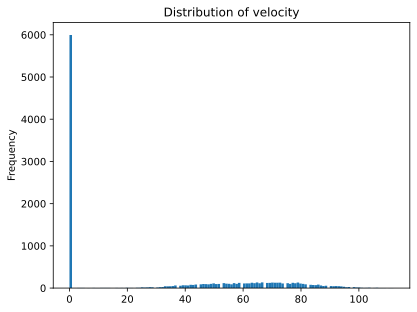

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

df_note_on["velocity"].plot.hist(title="Distribution of velocity", bins=127);

We see a lot of unexpected velocities of $1$, which needs some further inspection.
For now we will simply filter them out easily with pandas.

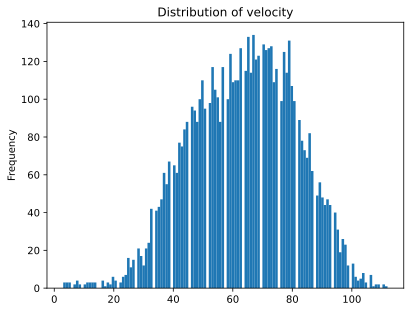

In [ ]:
df_note_on = df_note_on[df_note_on["velocity"] > 1]

df_note_on["velocity"].plot.hist(title="Distribution of velocity", bins=127);

Although MIDI can store information such as tempo and time signature, it is not required to do so.
For this project, this information is not important because the performances in our dataset are not tied to a consistent tempo via a click track.

While traditional sheet music is derived from a visual representation, MIDI does not rely on a visual representation and instead attempts to capture a stream of keyboard events on a timeline.
However, a common method of visually representing MIDI data is the [piano roll](https://en.wikipedia.org/wiki/Piano_roll), which is derived from the traditional piano roll of player pianos.

The $x$ axis represents time, while the $y$ axis represents the possible keys on a piano (of which there are 88 on a traditional grand piano).
If a key $k$ is pressed at a time $t$, the point $(t, k)$ is mapped to $>0$, and if no key is pressed, it is mapped to $0$.

In [ ]:
# 10e3 scales our timing from ms to ns
df_time = df_note_on.copy()
df_time["time"] = pd.to_timedelta(df_note_on["time"] * 10e3)
df_time

,time,pitch,velocity
0,0 days 00:00:00.007880,59,38
1,0 days 00:00:00.007990,47,25
2,0 days 00:00:00.014840,61,53
3,0 days 00:00:00.015020,49,33
6,0 days 00:00:00.019040,56,57
...,...,...,...
11975,0 days 00:00:05.251500,52,82
11976,0 days 00:00:05.251500,64,94
11984,0 days 00:00:05.261650,52,104
11985,0 days 00:00:05.261750,28,87


In [ ]:
df_piano_roll = df_time.pivot_table(
    columns="pitch",
    index="time",
    values="velocity",
    aggfunc="max",
).fillna(0.0)

df_piano_roll

pitch,24,25,26,27,28,30,31,32,33,34,...,92,93,94,95,96,97,98,99,100,101
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00.007880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.007990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.014840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.015020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.019040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:05.251490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:05.251500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:05.261650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can already plot this pivot table now.

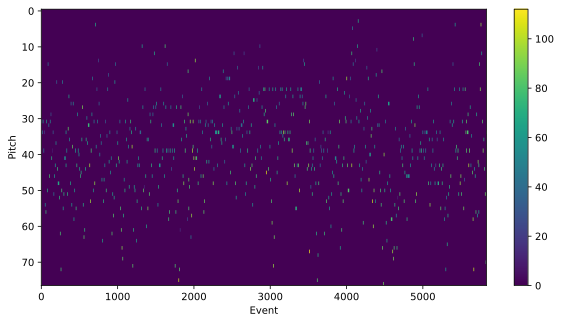

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(df_piano_roll.values.T, interpolation="nearest", aspect="auto")
plt.xlabel("Event")
plt.ylabel("Pitch")
plt.colorbar();

But in fact, we are plotting consecutive events on the $x$ axis instead of their time property.
To use the actual *time* of our events as the $x$ axis, we need to resample and aggregate our data.

In [ ]:
df_resampled_piano_roll = df_piano_roll.resample("25ms").max()
df_resampled_piano_roll

pitch,24,25,26,27,28,30,31,32,33,34,...,92,93,94,95,96,97,98,99,100,101
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00.007880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.032880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.057880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.082880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.107880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:05.157880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:05.182880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112.0,95.0,111.0,100.0,0.0,101.0,54.0,0.0,0.0,0.0
0 days 00:00:05.207880,0.0,0.0,0.0,0.0,93.0,55.0,0.0,80.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


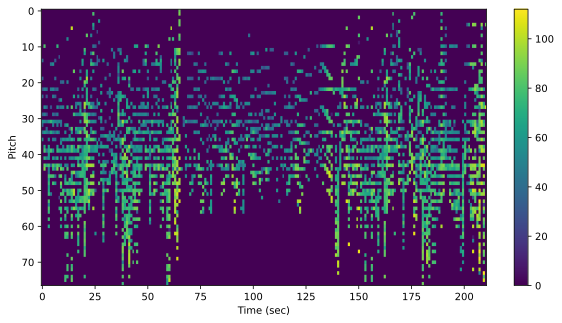

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(df_resampled_piano_roll.values.T, interpolation="nearest", aspect="auto")
plt.xlabel("Time steps (25 ms)")
plt.ylabel("Pitch")
plt.colorbar();

Proper parsing and extraction of our data will actually be the most labor intensive task for our project, as with any data related project.

Most of this task has been "outsourced" into a library `ki_ueben`, which is documented in {doc}`../ki_ueben_api`.

```{admonition} Tasks
* Investigate why there are so many velocity $1$ events in our MIDI file.
* Compare two MIDI files - what different kinds of data analysis and plotting methods can you find to compare these files?
* Include the `note_off' events in our piano roll so that we can distinguish how long a note is held down.
* What are good vector representations of our MIDI events? Find a [*a hot encoding*](https://en.wikipedia.org/wiki/One-hot) for the MIDI data.
```